# Neural Style Transfer using Pytorch

### Importing libraries

In [0]:
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Using VGG19 (features)

In [3]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 90549512.82it/s]


In [4]:
## select cuda if GPU available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load content and style Image

In [0]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(ByteIO(respons.content)).convert("RBG")
    else:
        image = Image.open(img_path)
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([transforms.Resize(size),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

In [0]:
content = load_image("lion.jpg").to(device)
style = load_image('style.jpg', shape=content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.256, 0.206))
    image = image.clip(0, 1)
    
    return image

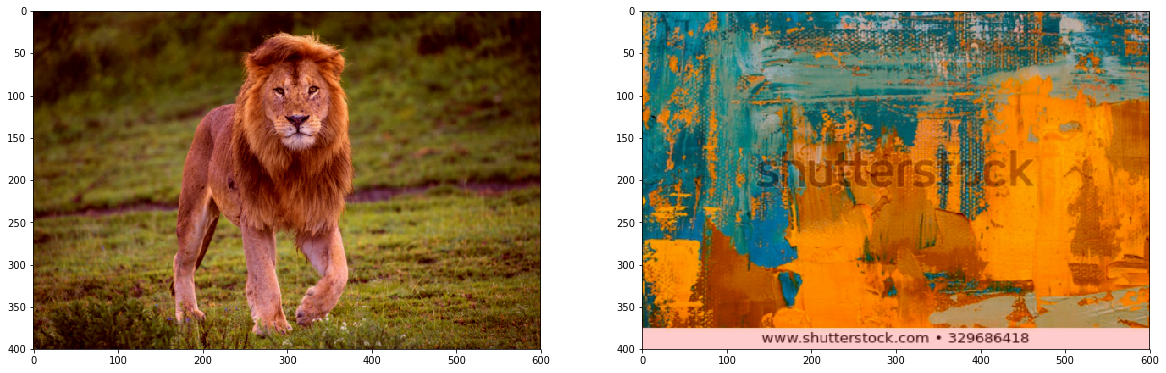

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## VGG19 Layers


In [10]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Content and Style Features

In [0]:
## Layers found in Paper

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 "10": "conv3_1",
                 "19": "conv4_1",
                 "21": "conv4_2",
                 "28": "conv5_1"}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

### Gram Matrix

In [0]:
def gram_matrix(tensor):
    _, d, h, w = tensor.shape
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

### Loss and Weights

In [0]:
## style weights from paper

style_weights = {'conv1_1': 1.,
                'conv2_1': 0.8,
                'conv3_1': 0.5,
                'conv4_1': 0.3,
                'conv5_1': 0.1}

content_weight = 1
style_weight = 1e6

### Update and calculate target loss

Total loss:  193141040.0
step:  400


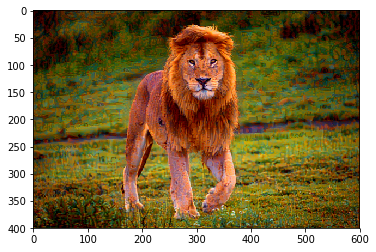

Total loss:  99048760.0
step:  800


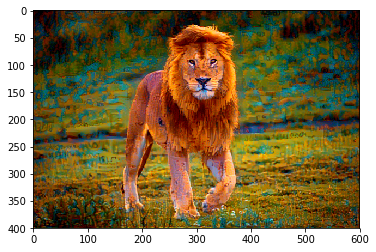

Total loss:  46954120.0
step:  1200


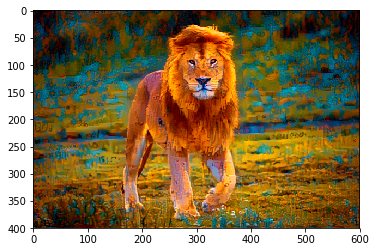

Total loss:  21764758.0
step:  1600


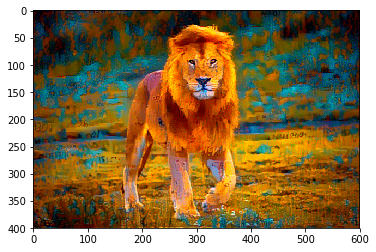

Total loss:  10859595.0
step:  2000


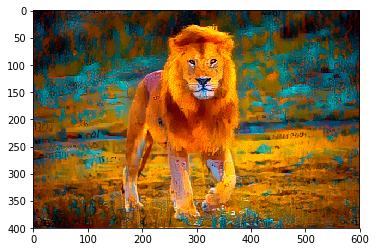

In [19]:
## more epochs can perform better style transfer
show_every = 400

## select the optimizer
optimizer = optim.Adam([target], lr=0.003)
steps = 2000

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    
    ## calculate the mean of layers of target features and content features
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    ## calculate style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    ## clear the gradients each iteration before calling loss.backward() for back-propogation 
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print("Total loss: ", total_loss.item())
        print("step: ", ii)
        plt.imshow(im_convert(target))
        plt.show()

### Display Content Image, Target Image, Style Image

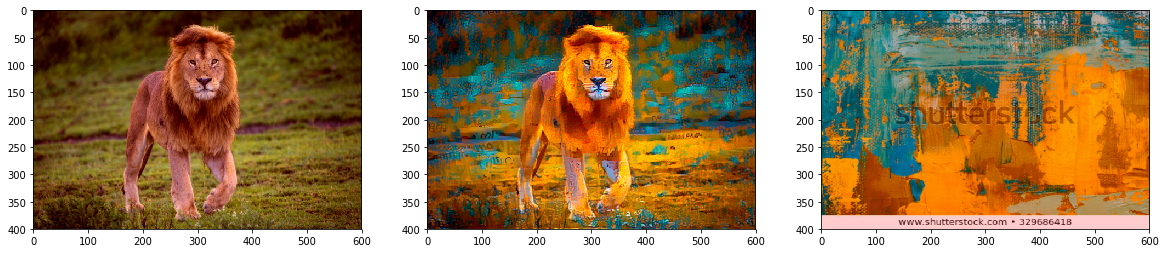

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(style))